# Example: Predictions for HRES at 0.1 deg

In this example, we will download HRES data for 11 May 2022 from the [Research Data Archive](https://rda.ucar.edu/datasets/d113001/#) at 0.1 degree resolution and run Aurora on this data. We will use the version of Aurora that was fine-tuned on IFS HRES 0.1 degree.

Running this notebook requires additional Python packages. You can install these as follows:

```
pip install xarray zarr netcdf4 cfgrib scipy matplotlib
```


## Downloading the Data

To start, we download the data from [Research Data Archive](https://rda.ucar.edu/datasets/d113001/#).

In [1]:
from pathlib import Path

import xarray as xr

from aurora.util import download_hres_rda_atmos, download_hres_rda_static, download_hres_rda_surf

# Data will be downloaded here.
download_path = Path("~/downloads/hres_0.1")

download_path = download_path.expanduser()
download_path.mkdir(parents=True, exist_ok=True)

# Day to download. This will download all times for that day.
day = "11"
month = "05"
year = "2022"

# Each variable has a number associated with it. This is the number that
# will be used in the RDA request.
var_nums = {
    "msl": "151",  # Mean sea level pressure
    "10u": "165",  # 10m u-component of wind
    "10v": "166",  # 10m v-component of wind
    "2t": "167",  # 2m temperature
    "z": "129",  # Geopotential
    "t": "130",  # Temperature
    "u": "131",  # u-component of wind (atmos)
    "v": "132",  # v-component of wind (atmos)
    "q": "133",  # Specific humidity (atmos)
    "slt": "043",  # Soil type
    "lsm": "172",  # Land sea mask
}

surface_vars = ["msl", "10u", "10v", "2t"]
atmos_vars = ["z", "t", "u", "v", "q"]
static_vars = ["z", "lsm", "slt"]

# Download surface variables. We write the downloaded data to cache.
for variable in surface_vars:
    if not (download_path / f"{variable}_{year}_{month}_{day}.grb").exists():
        download_hres_rda_surf(
            save_dir=download_path,
            year=year,
            month=month,
            day=day,
            variable=variable,
            var_dict=var_nums,
        )
    else:
        print(f"{variable} already downloaded")

# Download atmospheric variables. We write the downloaded data to cache.
# Each variable has 4 times per day, each of which is a separate file.
# This will take a few minutes.
for variable in atmos_vars:
    for timeofday in ["00", "06", "12", "18"]:
        if not (download_path / f"{variable}_{year}_{month}_{day}_{timeofday}.grb").exists():
            download_hres_rda_atmos(
                save_dir=download_path,
                year=year,
                month=month,
                day=day,
                variable=variable,
                var_dict=var_nums,
                timeofday=timeofday,
            )
        else:
            print(f"{variable} at time {timeofday} already downloaded")

# Download static variables. We write the downloaded data to cache.
for variable in static_vars:
    if not (download_path / f"static_{variable}.grb").exists():
        download_hres_rda_static(
            save_dir=download_path,
            year=year,
            month=month,
            day=day,
            variable=variable,
            var_dict=var_nums,
        )
    else:
        print(f"{variable} already downloaded")

/home/t-analucic/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


msl already downloaded
10u already downloaded
10v already downloaded
2t already downloaded
z at time 00 already downloaded
z at time 06 already downloaded
z at time 12 already downloaded
z at time 18 already downloaded
t at time 00 already downloaded
t at time 06 already downloaded
t at time 12 already downloaded
t at time 18 already downloaded
u at time 00 already downloaded
u at time 06 already downloaded
u at time 12 already downloaded
u at time 18 already downloaded
v at time 00 already downloaded
v at time 06 already downloaded
v at time 12 already downloaded
v at time 18 already downloaded
q at time 00 already downloaded
q at time 06 already downloaded
q at time 12 already downloaded
q at time 18 already downloaded
z already downloaded
lsm already downloaded
slt already downloaded


In [2]:
# Combine the surface data into a single dataset.
if not (download_path / f"{year}_{month}_{day}-surface-level-0.1deg.nc").exists():
    msl = xr.open_dataset(download_path / f"msl_{year}_{month}_{day}.grb", engine="cfgrib")
    u10 = xr.open_dataset(download_path / f"10u_{year}_{month}_{day}.grb", engine="cfgrib")
    v10 = xr.open_dataset(download_path / f"10v_{year}_{month}_{day}.grb", engine="cfgrib")
    t2m = xr.open_dataset(download_path / f"2t_{year}_{month}_{day}.grb", engine="cfgrib")
    ds_surf = xr.merge([msl, u10, v10, t2m])
    ds_surf.to_netcdf(download_path / f"{year}_{month}_{day}-surface-level-0.1deg.nc")

# Combine the atmospheric data into a single dataset. This will take a few minutes.
if not (download_path / f"{year}_{month}_{day}-atmospheric-0.1deg.nc").exists():
    q_00 = xr.open_dataset(download_path / f"q_{year}_{month}_{day}_00.grb", engine="cfgrib")
    q_06 = xr.open_dataset(download_path / f"q_{year}_{month}_{day}_06.grb", engine="cfgrib")
    q_12 = xr.open_dataset(download_path / f"q_{year}_{month}_{day}_12.grb", engine="cfgrib")
    q_18 = xr.open_dataset(download_path / f"q_{year}_{month}_{day}_18.grb", engine="cfgrib")

    t_00 = xr.open_dataset(download_path / f"t_{year}_{month}_{day}_00.grb", engine="cfgrib")
    t_06 = xr.open_dataset(download_path / f"t_{year}_{month}_{day}_06.grb", engine="cfgrib")
    t_12 = xr.open_dataset(download_path / f"t_{year}_{month}_{day}_12.grb", engine="cfgrib")
    t_18 = xr.open_dataset(download_path / f"t_{year}_{month}_{day}_18.grb", engine="cfgrib")

    u_00 = xr.open_dataset(download_path / f"u_{year}_{month}_{day}_00.grb", engine="cfgrib")
    u_06 = xr.open_dataset(download_path / f"u_{year}_{month}_{day}_06.grb", engine="cfgrib")
    u_12 = xr.open_dataset(download_path / f"u_{year}_{month}_{day}_12.grb", engine="cfgrib")
    u_18 = xr.open_dataset(download_path / f"u_{year}_{month}_{day}_18.grb", engine="cfgrib")

    v_00 = xr.open_dataset(download_path / f"v_{year}_{month}_{day}_00.grb", engine="cfgrib")
    v_06 = xr.open_dataset(download_path / f"v_{year}_{month}_{day}_06.grb", engine="cfgrib")
    v_12 = xr.open_dataset(download_path / f"v_{year}_{month}_{day}_12.grb", engine="cfgrib")
    v_18 = xr.open_dataset(download_path / f"v_{year}_{month}_{day}_18.grb", engine="cfgrib")

    z_00 = xr.open_dataset(download_path / f"z_{year}_{month}_{day}_00.grb", engine="cfgrib")
    z_06 = xr.open_dataset(download_path / f"z_{year}_{month}_{day}_06.grb", engine="cfgrib")
    z_12 = xr.open_dataset(download_path / f"z_{year}_{month}_{day}_12.grb", engine="cfgrib")
    z_18 = xr.open_dataset(download_path / f"z_{year}_{month}_{day}_18.grb", engine="cfgrib")

    q = xr.concat([q_00, q_06, q_12, q_18], dim="time")
    t = xr.concat([t_00, t_06, t_12, t_18], dim="time")
    u = xr.concat([u_00, u_06, u_12, u_18], dim="time")
    v = xr.concat([v_00, v_06, v_12, v_18], dim="time")
    z = xr.concat([z_00, z_06, z_12, z_18], dim="time")

    ds_atmos = xr.merge([q, t, u, v, z])
    ds_atmos.to_netcdf(download_path / f"{year}_{month}_{day}-atmospheric-0.1deg.nc")

# Combine the static data into a single dataset.
if not (download_path / "static-0.1deg.nc").exists():
    z_static = xr.open_dataset(download_path / "static_z.grb", engine="cfgrib")
    lsm = xr.open_dataset(download_path / "static_lsm.grb", engine="cfgrib")
    slt = xr.open_dataset(download_path / "static_slt.grb", engine="cfgrib")

    ds_static = xr.merge([z_static, lsm, slt])
    ds_static.to_netcdf(download_path / "static-0.1deg.nc")

## Preparing a Batch

We convert the downloaded data to an `aurora.Batch`, which is what the model requires.

In [5]:
import numpy as np
import torch

from aurora import Batch, Metadata

static_vars_ds = xr.open_dataset(download_path / "static-0.1deg.nc", engine="netcdf4")
surf_vars_ds = xr.open_dataset(
    download_path / f"{year}_{month}_{day}-surface-level-0.1deg.nc", engine="netcdf4"
)
atmos_vars_ds = xr.open_dataset(
    download_path / f"{year}_{month}_{day}-atmospheric-0.1deg.nc", engine="netcdf4"
)

# Aurora is trained on 13 pressure levels.
levels = [50.0, 100.0, 150.0, 200.0, 250.0, 300.0, 400.0, 500.0, 600.0, 700.0, 850.0, 925.0, 1000.0]
atmos_vars_ds = atmos_vars_ds.sel(isobaricInhPa=levels)

i = 1  # Select this time index in the downloaded data.


def _prepare(x: np.ndarray) -> torch.Tensor:
    """Prepare a variable.

    This does the following things:
    * Select time indices `i` and `i - 1`.
    * Insert an empty batch dimension with `[None]`.
    * Convert to PyTorch.
    """
    return torch.from_numpy(x[[i - 1, i]][None])


# Creating the batch will take a few minutes.
batch = Batch(
    surf_vars={
        "2t": _prepare(surf_vars_ds["t2m"].values),
        "10u": _prepare(surf_vars_ds["u10"].values),
        "10v": _prepare(surf_vars_ds["v10"].values),
        "msl": _prepare(surf_vars_ds["msl"].values),
    },
    static_vars={
        # The static variables are constant, so we just get them for the first time.
        "z": torch.from_numpy(static_vars_ds["z"].values[0]),
        "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
        "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
    },
    atmos_vars={
        "t": _prepare(atmos_vars_ds["t"].values),
        "u": _prepare(atmos_vars_ds["u"].values),
        "v": _prepare(atmos_vars_ds["v"].values),
        "q": _prepare(atmos_vars_ds["q"].values),
        "z": _prepare(atmos_vars_ds["z"].values),
    },
    metadata=Metadata(
        lat=torch.from_numpy(surf_vars_ds.latitude.values.copy()),
        lon=torch.from_numpy(surf_vars_ds.longitude.values),
        # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
        # `datetime.datetime`s. Note that this needs to be a tuple of length one:
        # one value for every batch element.
        time=(surf_vars_ds.time.values.astype("datetime64[s]").tolist()[i],),
        atmos_levels=tuple(int(level) for level in atmos_vars_ds.isobaricInhPa.values),
    ),
)
batch = batch.regrid(res=0.1)

## Loading and Running the Model

Finally, we are ready to load and run the model and visualise the predictions. We perform a roll-out for two steps, which produces predictions for hours 12:00 and 18:00.

In [11]:
from aurora import AuroraHighRes, rollout

model = AuroraHighRes(use_lora=True, autocast=True)
model.load_checkpoint("wbruinsma/aurora", "aurora-0.1-finetuned.ckpt", strict=True)

model.eval()
model = model.to("cuda")

with torch.inference_mode():
    preds = [pred.to("cpu") for pred in rollout(model, batch, steps=2)]

model = model.to("cpu")

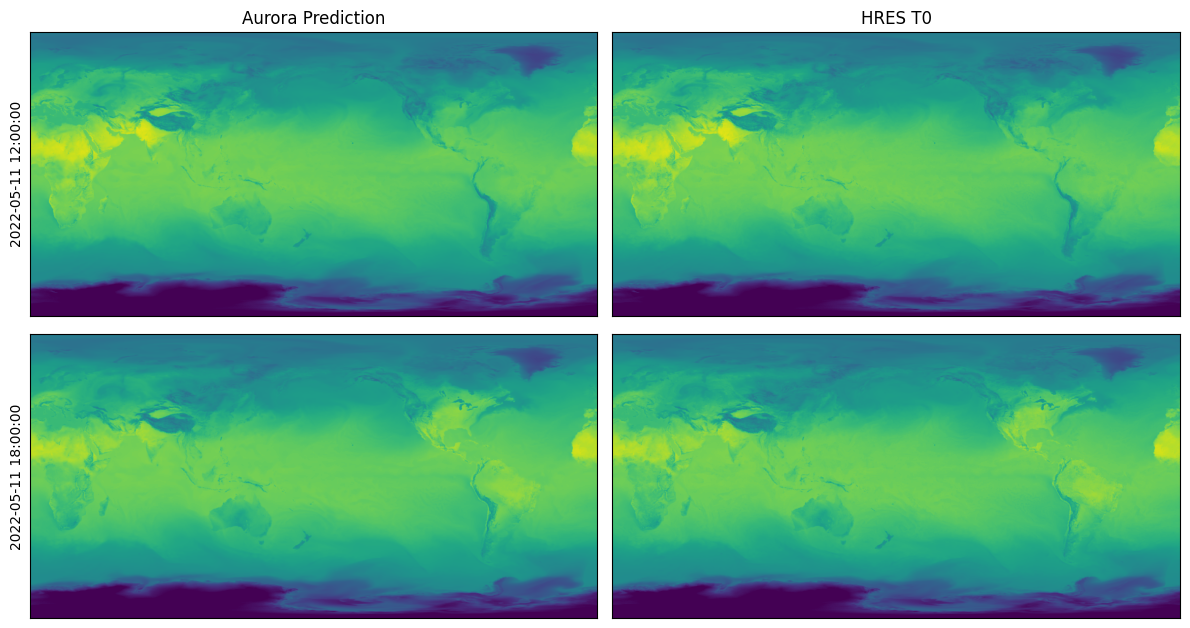

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(12, 6.5))

for i in range(ax.shape[0]):
    pred = preds[i]

    ax[i, 0].imshow(pred.surf_vars["2t"][0, 0].numpy() - 273.15, vmin=-50, vmax=50)
    ax[i, 0].set_ylabel(str(pred.metadata.time[0]))
    if i == 0:
        ax[i, 0].set_title("Aurora Prediction")
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])

    ref = surf_vars_ds["t2m"][2 + i].values
    ax[i, 1].imshow(ref - 273.15, vmin=-50, vmax=50)
    if i == 0:
        ax[i, 1].set_title("HRES T0")
    ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])

plt.tight_layout()